In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import talib
import seaborn as sns
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
import xgboost as xgb
from sklearn.feature_selection import VarianceThreshold
from sklearn.ensemble import RandomForestRegressor

In [212]:
df = pd.read_csv('../data/processed_data/gspc.csv', index_col=0)

In [213]:
df.columns

Index(['close', 'high', 'low', 'open', 'volume', 'sma_50', 'sma_200',
       'golden_cross', 'death_cross', 'daily_return', 'rolling_volatility',
       'rolling_vol', 'returns', 'egarch_vol'],
      dtype='object')

In [214]:
df.drop(['golden_cross', 'death_cross'], axis=1, inplace=True)

In [215]:
df.isna().sum()

close                   0
high                    0
low                     0
open                    0
volume                  0
sma_50                 49
sma_200               199
daily_return            1
rolling_volatility     21
rolling_vol            21
returns                 1
egarch_vol             66
dtype: int64

## Basic technical indicators

In [216]:
df['sma_10'] = df['close'].rolling(window=10, min_periods=1).mean()
df['sma_30'] = df['close'].rolling(window=30, min_periods=1).mean()
df['ema_10'] = df['close'].ewm(span=10, adjust=False).mean()
df['ema_30'] = df['close'].ewm(span=30, adjust=False).mean()
df['ema_100'] = df['close'].ewm(span=100, adjust=False).mean()

In [217]:
window = 14
delta = df['close'].diff()
gain = delta.where(delta > 0, 0)
loss = -delta.where(delta < 0, 0)
avg_gain = gain.ewm(span=window, min_periods=window).mean()
avg_loss = loss.ewm(span=window, min_periods=window).mean()
rs = avg_gain / avg_loss
df['rsi'] = 100 - (100 / (1 + rs))

In [218]:
short_ema = df['close'].ewm(span=12, adjust=False).mean()
long_ema = df['close'].ewm(span=26, adjust=False).mean()
df['macd'] = short_ema - long_ema

In [219]:
df['signal_line'] = df['macd'].ewm(span=9, adjust=False).mean()

In [220]:
df['roc'] = df['close'].pct_change(periods=12) * 100

In [221]:
high_low = df['high'] - df['low']
high_close = abs(df['high'] - df['close'].shift(1))
low_close = abs(df['low'] - df['close'].shift(1))
true_range = np.maximum(high_low, np.maximum(high_close, low_close))
df['atr'] = true_range.rolling(window=14).mean()

In [222]:
df['engulfing'] = talib.CDLENGULFING(df['open'], df['high'], df['low'], df['close'])
df['doji'] = talib.CDLDOJI(df['open'], df['high'], df['low'], df['close'])
df['hammer'] = talib.CDLHAMMER(df['open'], df['high'], df['low'], df['close'])
df['shooting_star'] = talib.CDLSHOOTINGSTAR(df['open'], df['high'], df['low'], df['close'])

In [223]:
df['adx'] = talib.ADX(df['high'], df['low'], df['close'], timeperiod=14)
df['cci'] = talib.CCI(df['high'], df['low'], df['close'], timeperiod=14)

In [224]:
df['upper_bb'], df['middle_bb'], df['lower_bb'] = talib.BBANDS(df['close'], timeperiod=20, nbdevup=2, nbdevdn=2)
df['bb_width'] = (df['upper_bb'] - df['lower_bb']) / df['middle_bb']

In [225]:
df['obv'] = talib.OBV(df['close'], df['volume'])
df['mfi'] = talib.MFI(df['high'], df['low'], df['close'], df['volume'], timeperiod=14)

In [226]:
def charts(df, column, title=None):
    plt.figure(figsize=(12,5))
    plt.plot(df[column], label=column, color='blue')
    plt.title(title if title else column)
    plt.xlabel('Date')
    plt.ylabel(column)
    plt.legend()
    plt.grid(True)
    plt.show()

In [227]:
indicators = ['close', 'sma_10', 'sma_30', 'ema_10', 'ema_30', 'ema_100', 
              'rsi', 'adx', 'cci', 'obv', 'mfi', 'upper_bb', 'lower_bb', 'bb_width']

In [228]:
print(df[indicators].describe())

             close       sma_10       sma_30       ema_10       ema_30  \
count  1258.000000  1258.000000  1258.000000  1258.000000  1258.000000   
mean   4259.606933  4249.951726  4228.122851  4249.938614  4228.359249   
std     767.448592   760.778688   744.531392   759.544948   742.246943   
min    2237.399902  2435.955981  2609.232316  2486.247270  2690.509816   
25%    3819.052551  3817.765015  3834.461519  3825.889542  3842.908190   
50%    4204.880127  4209.534009  4185.600024  4211.082209  4183.596842   
75%    4603.890137  4609.750452  4576.935368  4603.865795  4565.068751   
max    6090.270020  6065.085010  5999.803678  6053.401494  5989.419791   

           ema_100          rsi          adx          cci           obv  \
count  1258.000000  1245.000000  1231.000000  1245.000000  1.258000e+03   
mean   4159.429120    56.014564    23.075399    28.618013  1.462178e+11   
std     687.352170    15.766242     8.202581   106.591214  6.896835e+10   
min    2932.580078     9.022777  

## Featuring Transformation

In [229]:
df['log_close'] = np.log(df['close'])
df['log_high_low'] = np.log(df['high'] - df['low'])
df['log_volume'] = np.log(df['volume'] + 1)
df['close_diff'] = df['close'].diff()
df['returns_diff'] = df['returns'].diff()

In [230]:
df['sma_ratio'] = df['sma_50'] / df['sma_200']
df['volatility_volume'] = df['rolling_vol'] * df['volume']
df['returns_volume'] = df['returns'] * df['volume']

In [231]:
df['volatility_squared'] = df['rolling_vol'] ** 2
df['volatility_sqrt'] = np.sqrt(df['rolling_vol'])

In [232]:
transformation = ['close', 'log_close', 'log_high_low', 'log_volume', 'close_diff', 'returns_diff',
                  'sma_ratio', 'volatility_volume', 'returns_volume', 'volatility_squared', 'volatility_sqrt']
print(df[transformation].describe())

             close    log_close  log_high_low   log_volume   close_diff  \
count  1258.000000  1258.000000   1258.000000  1258.000000  1257.000000   
mean   4259.606933     8.340419      3.795271    22.175815     2.087335   
std     767.448592     0.183395      0.550436     0.214464    48.711515   
min    2237.399902     7.713070      2.016269    21.217657  -324.890137   
25%    3819.052551     8.247758      3.422384    22.045291   -22.889648   
50%    4204.880127     8.344001      3.793465    22.137470     3.949707   
75%    4603.890137     8.434657      4.168249    22.273571    30.060059   
max    6090.270020     8.714448      5.388889    23.023500   230.380127   

       returns_diff    sma_ratio  volatility_volume  returns_volume  \
count   1256.000000  1059.000000       1.237000e+03    1.257000e+03   
mean       0.000002     1.042829       8.444058e+08    1.376671e+06   
std        0.020672     0.055838       8.784840e+08    8.268029e+07   
min       -0.212712     0.899372       1

In [233]:
corr = df.corr()
high_corr = np.sum((corr > 0.8) & (corr < 1))
low_corr = np.sum((corr < -0.8) & (corr > -1))
print(f'High correlation > 0.8: {high_corr}')
print(f'Low correlation < -0.8: {low_corr}')

High correlation > 0.8: close                 15
high                  15
low                   15
open                  15
volume                 1
sma_50                15
sma_200               14
daily_return           2
rolling_volatility     5
rolling_vol            5
returns                2
egarch_vol             0
sma_10                15
sma_30                15
ema_10                15
ema_30                15
ema_100               15
rsi                    1
macd                   1
signal_line            1
roc                    0
atr                    3
engulfing              0
doji                   0
hammer                 0
shooting_star          0
adx                    0
cci                    1
upper_bb              15
middle_bb             15
lower_bb              15
bb_width               5
obv                   14
mfi                    0
log_close             15
log_high_low           0
log_volume             1
close_diff             3
returns_diff           0
s

c:\Users\santi\anaconda3\Lib\site-packages\numpy\core\fromnumeric.py:86: FutureWarning: The behavior of DataFrame.sum with axis=None is deprecated, in a future version this will reduce over both axes and return a scalar. To retain the old behavior, pass axis=0 (or do not pass axis)
  return reduction(axis=axis, out=out, **passkwargs)


## PCA

In [234]:
df_numeric = df.select_dtypes(include=[np.number]).dropna()

In [235]:
scaler = StandardScaler()
df_scaled = scaler.fit_transform(df_numeric)
df_scaled = pd.DataFrame(df_scaled, columns=df_numeric.columns, index=df_numeric.index)

In [236]:
pca = PCA()
pca.fit(df_scaled)

PCA()

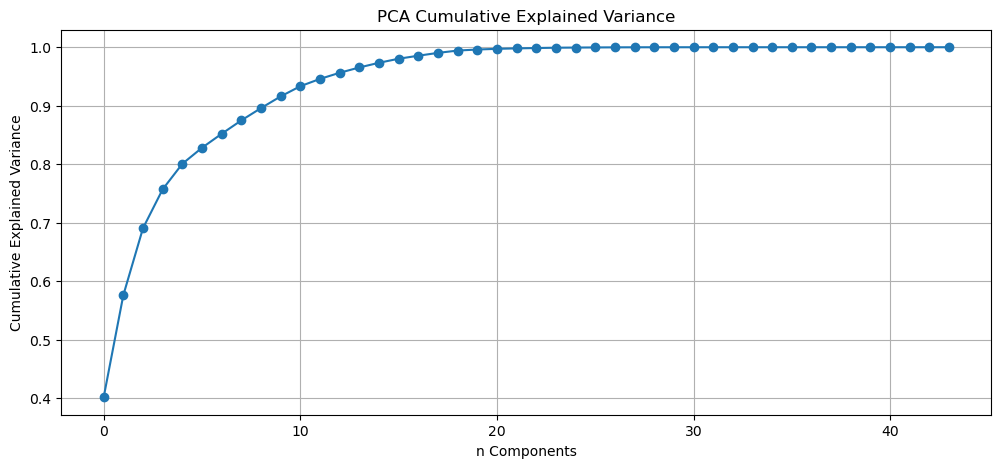

In [237]:
plt.figure(figsize=(12,5))
plt.plot(np.cumsum(pca.explained_variance_ratio_), marker='o')
plt.xlabel('n Components')
plt.ylabel('Cumulative Explained Variance')
plt.title('PCA Cumulative Explained Variance')
plt.grid()
plt.show()

In [238]:
total_explained_variance = np.cumsum(pca.explained_variance_ratio_)
num_components_95 = np.argmax(total_explained_variance >= 0.95) + 1

In [239]:
print(f'Number of components to explain 95% of variance: {num_components_95}')

Number of components to explain 95% of variance: 13


## Feature Selection

In [240]:
X = df.drop(columns=['close'])
y = df['close']

In [241]:
model = xgb.XGBRegressor(n_estimators=100, max_depth=3, learning_rate=0.1, random_state=42)

In [242]:
model.fit(X, y)

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.1, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=3, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=100, n_jobs=None,
             num_parallel_tree=None, random_state=42, ...)

In [243]:
importances = model.feature_importances_
importance_df = pd.DataFrame({'Feature': X.columns, 'Importance': importances})
importance_df = importance_df.sort_values(by='Importance', ascending=False)
print(importance_df.head(15))

              Feature  Importance
33          log_close    0.639564
0                high    0.165646
1                 low    0.071922
27           upper_bb    0.038815
28          middle_bb    0.027644
5             sma_200    0.022493
13             ema_10    0.007845
12             sma_30    0.006740
4              sma_50    0.006013
14             ema_30    0.004254
2                open    0.004228
11             sma_10    0.001531
31                obv    0.001306
39  volatility_volume    0.000405
29           lower_bb    0.000340


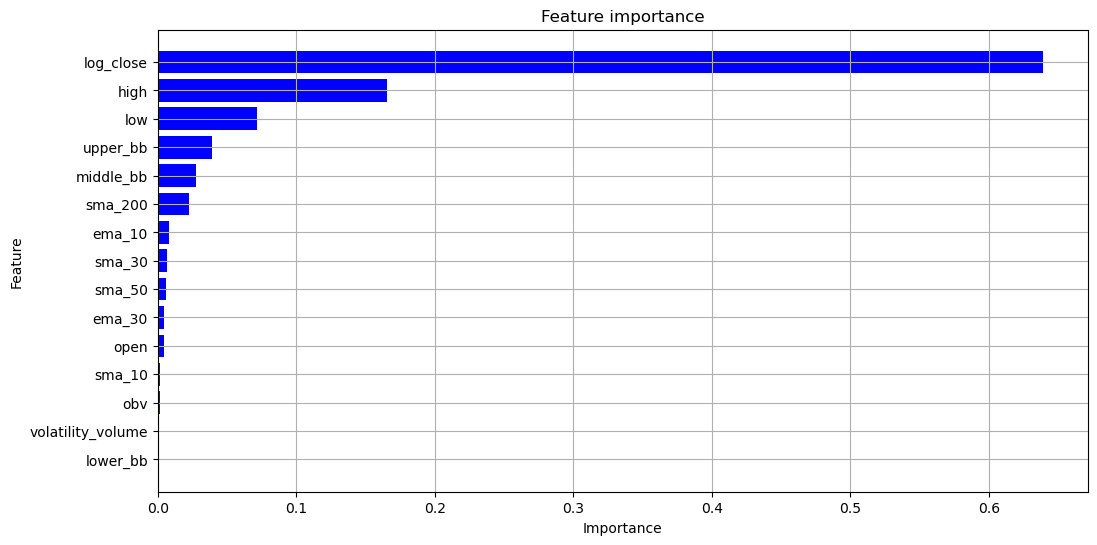

In [244]:
plt.figure(figsize=(12, 6))
plt.barh(importance_df['Feature'].head(15), importance_df['Importance'].head(15), color='blue')
plt.xlabel('Importance')
plt.ylabel('Feature')
plt.title('Feature importance')
plt.gca().invert_yaxis()
plt.grid(True)
plt.show()

In [245]:
corr_log_close = df.corr()['log_close'].sort_values(ascending=False)
print(corr_log_close)

log_close             1.000000
close                 0.991750
low                   0.991604
high                  0.990592
open                  0.990300
ema_10                0.987524
sma_10                0.986158
lower_bb              0.983992
middle_bb             0.979139
ema_30                0.978724
sma_30                0.973613
upper_bb              0.964133
sma_50                0.964034
ema_100               0.954760
sma_200               0.854728
obv                   0.843956
signal_line           0.366984
sma_ratio             0.350820
macd                  0.348251
mfi                   0.216707
rsi                   0.173442
adx                   0.160740
roc                   0.136893
cci                   0.088630
close_diff            0.052762
returns_volume        0.041672
daily_return          0.037399
returns               0.037399
shooting_star         0.020441
doji                  0.019754
returns_diff          0.007834
engulfing            -0.000717
hammer  

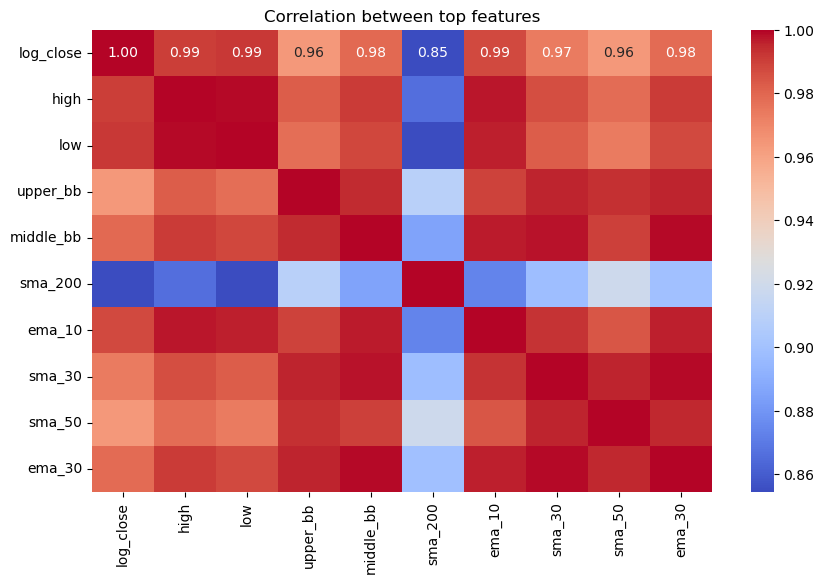

In [246]:
top_features = importance_df.head(10)
top_features = top_features['Feature'].tolist()
plt.figure(figsize=(10, 6))
sns.heatmap(df[top_features].corr(), annot=True, cmap='coolwarm', fmt=".2f")
plt.title("Correlation between top features")
plt.show()

In [247]:
print(df[top_features].corr())

           log_close      high       low  upper_bb  middle_bb   sma_200  \
log_close   1.000000  0.990592  0.991604  0.964133   0.979139  0.854728   
high        0.990592  1.000000  0.999235  0.982573   0.991373  0.865938   
low         0.991604  0.999235  1.000000  0.977544   0.988197  0.854410   
upper_bb    0.964133  0.982573  0.977544  1.000000   0.994814  0.909547   
middle_bb   0.979139  0.991373  0.988197  0.994814   1.000000  0.885579   
sma_200     0.854728  0.865938  0.854410  0.909547   0.885579  1.000000   
ema_10      0.987524  0.997711  0.996147  0.989345   0.997143  0.873696   
sma_30      0.973613  0.986873  0.982852  0.995998   0.998104  0.897758   
sma_50      0.964034  0.978249  0.973295  0.993339   0.990287  0.919175   
ema_30      0.978724  0.991363  0.987894  0.996019   0.998878  0.899197   

             ema_10    sma_30    sma_50    ema_30  
log_close  0.987524  0.973613  0.964034  0.978724  
high       0.997711  0.986873  0.978249  0.991363  
low        0.99614

In [248]:
selector = VarianceThreshold(threshold=0.01)
selector.fit(df)

VarianceThreshold(threshold=0.01)

In [249]:
low_variance_features = df.columns[~selector.get_support()]
print("Low variance features:", low_variance_features)

Low variance features: Index(['daily_return', 'rolling_volatility', 'returns', 'bb_width',
       'returns_diff', 'sma_ratio'],
      dtype='object')


In [250]:
X_no_log = df.drop(columns=['log_close','close'])
y = df['close']

In [251]:
model.fit(X_no_log, y)

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.1, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=3, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=100, n_jobs=None,
             num_parallel_tree=None, random_state=42, ...)

In [252]:
importance_no_log = pd.DataFrame({'Feature': X_no_log.columns, 'Importance': model.feature_importances_})
print(importance_no_log.sort_values(by='Importance', ascending=False))

               Feature  Importance
0                 high    0.346010
1                  low    0.335923
5              sma_200    0.193274
4               sma_50    0.031955
27            upper_bb    0.028780
2                 open    0.017281
13              ema_10    0.016131
20                 atr    0.009184
28           middle_bb    0.006236
31                 obv    0.004984
12              sma_30    0.003924
11              sma_10    0.001975
17                macd    0.001217
14              ema_30    0.000550
29            lower_bb    0.000506
39      returns_volume    0.000415
19                 roc    0.000323
35          close_diff    0.000301
15             ema_100    0.000262
6         daily_return    0.000196
16                 rsi    0.000097
36        returns_diff    0.000077
33        log_high_low    0.000061
10          egarch_vol    0.000053
32                 mfi    0.000038
23              hammer    0.000037
30            bb_width    0.000027
25                 a

In [253]:
features_to_drop = ['high', 'sma_30', 'ema_30']
df.drop(columns=features_to_drop, inplace=True, errors='ignore')

In [254]:
correlation = df.corr()['log_close'].sort_values(ascending=False)
print(correlation)

log_close             1.000000
close                 0.991750
low                   0.991604
open                  0.990300
ema_10                0.987524
sma_10                0.986158
lower_bb              0.983992
middle_bb             0.979139
upper_bb              0.964133
sma_50                0.964034
ema_100               0.954760
sma_200               0.854728
obv                   0.843956
signal_line           0.366984
sma_ratio             0.350820
macd                  0.348251
mfi                   0.216707
rsi                   0.173442
adx                   0.160740
roc                   0.136893
cci                   0.088630
close_diff            0.052762
returns_volume        0.041672
daily_return          0.037399
returns               0.037399
shooting_star         0.020441
doji                  0.019754
returns_diff          0.007834
engulfing            -0.000717
hammer               -0.021421
log_high_low         -0.114542
atr                  -0.319857
egarch_v

In [255]:
top_features = correlation.index[1:11]
selector = VarianceThreshold(threshold=0.001)

In [256]:
selector.fit(df)

VarianceThreshold(threshold=0.001)

In [257]:
low_variance_features = df.columns[~selector.get_support()]
print("Low variance features:", low_variance_features)

Low variance features: Index(['daily_return', 'returns', 'returns_diff'], dtype='object')


In [258]:
df_na = df.dropna()
X_no_log = df_na.drop(columns=['log_close', 'close'])
y = df_na['close']

In [259]:
rf = RandomForestRegressor(n_estimators=100, random_state=42)
rf.fit(X_no_log, y)

RandomForestRegressor(random_state=42)

In [260]:
feature_importance = pd.DataFrame({'Feature': X_no_log.columns, 'Importance': rf.feature_importances_})
print(feature_importance.sort_values(by='Importance', ascending=False))

               Feature    Importance
0                  low  4.185728e-01
11              ema_10  1.922230e-01
10              sma_10  1.597373e-01
25           middle_bb  1.241031e-01
1                 open  1.011065e-01
28                 obv  2.158626e-03
3               sma_50  3.156267e-04
4              sma_200  3.103033e-04
24            upper_bb  2.118351e-04
12             ema_100  1.926481e-04
26            lower_bb  1.565964e-04
36      returns_volume  8.194597e-05
30        log_high_low  7.117254e-05
33        returns_diff  6.650865e-05
32          close_diff  5.744128e-05
5         daily_return  5.538129e-05
34           sma_ratio  5.440642e-05
8              returns  5.086462e-05
27            bb_width  4.480042e-05
29                 mfi  4.171707e-05
16                 roc  3.898349e-05
9           egarch_vol  3.256951e-05
22                 adx  3.109475e-05
35   volatility_volume  2.832761e-05
13                 rsi  2.783927e-05
15         signal_line  2.659945e-05
6

In [261]:
model.fit(X_no_log, y)

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.1, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=3, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=100, n_jobs=None,
             num_parallel_tree=None, random_state=42, ...)

In [262]:
feature_importance = pd.DataFrame({'Feature': X_no_log.columns, 'Importance': model.feature_importances_})
print(feature_importance.sort_values(by='Importance', ascending=False))

               Feature  Importance
0                  low    0.716839
1                 open    0.077887
3               sma_50    0.054073
24            upper_bb    0.041100
10              sma_10    0.030219
11              ema_10    0.026228
25           middle_bb    0.016981
28                 obv    0.015684
4              sma_200    0.010683
12             ema_100    0.005965
32          close_diff    0.001108
5         daily_return    0.000776
36      returns_volume    0.000670
13                 rsi    0.000223
30        log_high_low    0.000207
16                 roc    0.000174
19                doji    0.000146
23                 cci    0.000126
20              hammer    0.000114
33        returns_diff    0.000093
26            lower_bb    0.000091
18           engulfing    0.000073
6   rolling_volatility    0.000073
21       shooting_star    0.000071
29                 mfi    0.000058
14                macd    0.000057
34           sma_ratio    0.000049
22                 a

In [263]:
drop_features = [
    "engulfing", "doji", "hammer", "shooting_star",
    "volatility_squared", "volatility_sqrt", "rolling_volatility", "rolling_vol",
    "log_volume", "returns", "sma_ratio"
]
df = df.drop(columns=drop_features)

In [264]:
# Combining features 
df["low_sma_10"] = df["low"] - df["sma_10"]
df["low_sma_50"] = df["low"] - df["sma_50"]
df["low_sma_200"] = df["low"] - df["sma_200"]

df["low_upper_bb"] = df["low"] - df["upper_bb"]
df["low_middle_bb"] = df["low"] - df["middle_bb"]
df["low_lower_bb"] = df["low"] - df["lower_bb"]

df["low_open"] = df["low"] - df["open"]

In [265]:
# Transformation 
df['log_volume'] = np.log1p(df['volume'])
df['log_obv'] = np.log1p(np.abs(df['obv']))
df['log_returns_volume'] = np.log1p(np.abs(df['returns_volume']))

In [266]:
X = df.drop(columns=['close', 'log_close'])
y = df['log_close']

In [267]:
model.fit(X, y)

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.1, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=3, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=100, n_jobs=None,
             num_parallel_tree=None, random_state=42, ...)

In [268]:
feature_importance = pd.DataFrame({'Feature': X.columns, 'Importance': model.feature_importances_})
print(feature_importance.sort_values(by='Importance', ascending=False))

               Feature  Importance
0                  low    0.373816
8               ema_10    0.178338
18           middle_bb    0.155198
14                 atr    0.087721
4              sma_200    0.080437
1                 open    0.067918
7               sma_10    0.020249
11                macd    0.009564
3               sma_50    0.006949
21                 obv    0.005604
17            upper_bb    0.004296
19            lower_bb    0.002843
29          low_sma_50    0.002308
13                 roc    0.001012
9              ema_100    0.000670
27      returns_volume    0.000667
12         signal_line    0.000449
24          close_diff    0.000434
5         daily_return    0.000285
10                 rsi    0.000220
15                 adx    0.000210
23        log_high_low    0.000137
25        returns_diff    0.000094
26   volatility_volume    0.000084
33        low_lower_bb    0.000066
32       low_middle_bb    0.000062
30         low_sma_200    0.000056
36             log_o

In [269]:
drop_features = [
    'log_volume', 'log_returns_volume', 'low_upper_bb', 'low_middle_bb', 'low_lower_bb', 'low_sma_200', 'log_obv'
]

In [270]:
df = df.drop(columns=drop_features)

In [271]:
df['obv_norm'] = df['obv']/df['obv'].abs().max()
df["low_bb_pct"] = (df["low"] - df["middle_bb"]) / df["middle_bb"]
df['low_atr_pct'] = df["low"] / df['atr']  

In [272]:
X = df.drop(columns=['close', 'log_close'])
y = df['log_close']

In [273]:
model.fit(X, y)

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.1, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=3, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=100, n_jobs=None,
             num_parallel_tree=None, random_state=42, ...)

In [274]:
feature_importance = pd.DataFrame({'Feature': X.columns, 'Importance': model.feature_importances_})
print(feature_importance.sort_values(by='Importance', ascending=False))

              Feature  Importance
0                 low    0.396678
8              ema_10    0.176834
18          middle_bb    0.146320
4             sma_200    0.104148
1                open    0.087387
33        low_atr_pct    0.036269
7              sma_10    0.017805
3              sma_50    0.007553
17           upper_bb    0.007110
21                obv    0.005410
11               macd    0.004799
19           lower_bb    0.003028
13                roc    0.001557
29         low_sma_50    0.001456
9             ema_100    0.000660
27     returns_volume    0.000617
12        signal_line    0.000469
24         close_diff    0.000421
10                rsi    0.000258
5        daily_return    0.000208
15                adx    0.000188
25       returns_diff    0.000146
22                mfi    0.000140
23       log_high_low    0.000116
20           bb_width    0.000107
28         low_sma_10    0.000050
32         low_bb_pct    0.000050
30           low_open    0.000049
16            

In [275]:
low_importance_features = feature_importance[feature_importance['Importance'] < 0.005]['Feature']
df.drop(columns=low_importance_features, inplace=True)
print(low_importance_features)

2                volume
5          daily_return
6            egarch_vol
9               ema_100
10                  rsi
11                 macd
12          signal_line
13                  roc
14                  atr
15                  adx
16                  cci
19             lower_bb
20             bb_width
22                  mfi
23         log_high_low
24           close_diff
25         returns_diff
26    volatility_volume
27       returns_volume
28           low_sma_10
29           low_sma_50
30             low_open
31             obv_norm
32           low_bb_pct
Name: Feature, dtype: object


In [276]:
X = df.drop(columns=['close', 'log_close'])
y = df['log_close']

In [277]:
model.fit(X, y)

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.1, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=3, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=100, n_jobs=None,
             num_parallel_tree=None, random_state=42, ...)

In [278]:
feature_importance = pd.DataFrame({'Feature': X.columns, 'Importance': model.feature_importances_})
print(feature_importance.sort_values(by='Importance', ascending=False))

       Feature  Importance
0          low    0.384612
5       ema_10    0.308142
7    middle_bb    0.168442
3      sma_200    0.058206
1         open    0.047886
9  low_atr_pct    0.014077
2       sma_50    0.007382
4       sma_10    0.005993
8          obv    0.002901
6     upper_bb    0.002359


In [279]:
df.to_csv('../data/pre_train/gspc.csv', index=True)